# Kyle Calabro
# DATA 750 - Thesis in Data Science
---

# Notebook Ten:
---
## Exploring Model Averaging Ensemble Classifiers on RAVDESS Data Sets

In [1]:
!pip install fsspec
!pip install gcsfs
!pip install h5py

import librosa
import librosa.display

%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.pyplot import specgram

import seaborn as sns

import IPython.display as ipd
from IPython.display import Audio

import seaborn as sns

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import sys
import warnings
import re

import time
import glob

from PIL import Image
from skimage import exposure, img_as_float

from scipy.optimize import differential_evolution

from itertools import product

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, InputLayer, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16, vgg19, InceptionV3, Xception, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# To ignore deprecation warnings...
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

np.random.seed(42)
#tf.random.set_random_seed(42)

     |████████████████████████████████| 132 kB 5.5 MB/s 
     |████████████████████████████████| 1.1 MB 7.9 MB/s 
     |████████████████████████████████| 271 kB 73.4 MB/s 
     |████████████████████████████████| 192 kB 72.6 MB/s 
     |████████████████████████████████| 160 kB 64.0 MB/s 


In [2]:
from google.colab import auth
auth.authenticate_user()

project_id = 'quantum-bonus-330300'
!gcloud config set project {project_id}
!gsutil ls

bucket_name = 'kpc_thesis'

Updated property [core/project].
gs://kpc_thesis/
gs://kpc_thesis_crema/


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Utility Functions
---

In [5]:
# To get the predicted labels of a given CNN model
# Params:
    # test_dataset: tf.data dataset containing image tensors and corresponding labels
    # model: the CNN model to make predictions with
    # encoder: The label encoder object used to encode labels initially

def get_predictions(test_dataset, model, encoder):
    y_pred = model.predict(test_dataset)
    y_pred = y_pred.argmax(axis = 1)
    y_pred = y_pred.astype(int).flatten()
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred

In [6]:
# To get the actual labels of a given CNN model
# Params:
    # y_test: target variable from the test set
    # encoder: The label encoder object used to encode labels initially

def get_labels(y_test, encoder):
    labels = y_test.argmax(axis = 1)
    labels = labels.astype(int).flatten()
    labels = encoder.inverse_transform(labels)
    return labels

In [7]:
# To print a classification report based on predictions from a CNN 
# and provided actual labels
# Params:
    # labels: The actual labels of the target variable
    # y_pred: The predicted labels of the target variable
    # encoder: The label encoder object used to encode labels initially
    
def get_report(labels, y_pred, encoder):
    target_names = encoder.classes_
    print(classification_report(labels, y_pred, target_names = target_names))

In [37]:
def get_confusion_matrix(labels, y_pred, encoder):
  target_names = encoder.classes_
  ConfusionMatrixDisplay.from_predictions(labels, y_pred, display_labels = target_names, cmap = plt.cm.Blues)
  plt.xticks(rotation = 90)
  plt.show()

In [9]:
# To load an image from a Google Cloud Storage Bucket and convert to grayscale

# Params:
  # path: path to the image in the GCS bucket
  # label: the label corresponding to the image given by the path

def load_images(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image)
  image = tf.cast(image, tf.float32) / 255.0

  return image, label

In [10]:
def ensemble_predictions(members, test_dataset, encoder):
  # Make predictions for individual classifiers
  y_pred = [model.predict(test_dataset) for model in members]
  y_pred = np.array(y_pred)

  # Sum predictions across the ensemble members
  y_pred = np.sum(y_pred, axis = 0)

  # Get predictions of the ensemble
  y_pred = np.argmax(y_pred, axis=1)
  y_pred = y_pred.astype(int).flatten()
  y_pred = encoder.inverse_transform(y_pred)
  return y_pred

# Bringing in the Data
----

In [11]:
regex = re.compile(r"\d+")

In [12]:
# Generate list of files containing the test images from the bucket
test_files = tf.io.gfile.glob("gs://kpc_thesis/Orig_Test/*.jpeg")

# Get the metadata of the images
test_metadata = pd.read_csv("gs://kpc_thesis/Orig_Test/orig_test_data.csv")
test_metadata.columns.values[0] = "corresponding_id"

# Match the images to their appropriate labels
index_list = [regex.findall(file)[0] for file in test_files]
index_list = list(map(int, index_list))

test_labels = [test_metadata.Emotion.iloc[index] for index in index_list]

In [13]:
print("Number of Testing Labels:", len(test_labels))

Number of Testing Labels: 288


In [14]:
# One-hot encoding
encoder = LabelEncoder()

y_test = to_categorical(encoder.fit_transform(test_labels))

In [15]:
print(encoder.classes_)

['Angry' 'Calm' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']


In [16]:
# Create TF datasets from the images and corresponding labels
test_dataset = tf.data.Dataset.from_tensor_slices((test_files, y_test))

In [17]:
test_dataset = (test_dataset.map(load_images, num_parallel_calls = AUTOTUNE)
            .batch(32)
            .prefetch(AUTOTUNE))
test_dataset

<PrefetchDataset shapes: ((None, None, None, None), (None, 8)), types: (tf.float32, tf.float32)>

# Model Averaging Ensembles
---

## Models trained on original data
----

In [18]:
# Load the models
path = "/content/drive/My Drive/Thesis/RAVDESS/orig_best_models/"
VGG16 = load_model(path + "E_VGG16_FT_Orig_Data.h5")
VGG19 = load_model(path + "E_VGG19_FT_Orig_Data.h5")
AlexNet = load_model(path + "E_AlexNet_Orig_Data2.h5")

models = [VGG16, VGG19, AlexNet]

In [19]:
y_pred = ensemble_predictions(models, test_dataset, encoder)

In [20]:
y_labels = get_labels(y_test, encoder)
get_report(y_labels, y_pred, encoder)

              precision    recall  f1-score   support

       Angry       0.79      0.77      0.78        35
        Calm       0.86      0.89      0.88        36
     Disgust       0.82      0.82      0.82        39
        Fear       0.81      0.72      0.76        40
       Happy       0.80      0.78      0.79        36
     Neutral       0.90      0.79      0.84        24
         Sad       0.58      0.68      0.63        38
    Surprise       0.90      0.93      0.91        40

    accuracy                           0.80       288
   macro avg       0.81      0.80      0.80       288
weighted avg       0.80      0.80      0.80       288



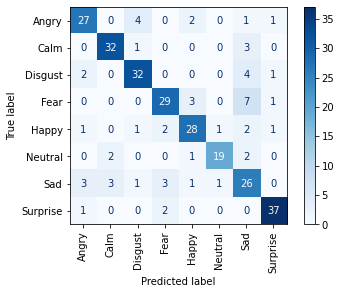

In [38]:
get_confusion_matrix(y_labels, y_pred, encoder)

## Models trained on augmented data
---

In [29]:
aug_path = "/content/drive/My Drive/Thesis/RAVDESS/aug_best_models/"
aug_VGG16 = load_model(aug_path + "E_VGG16_FT_Aug_Data.h5")
aug_VGG19 = load_model(aug_path + "E_VGG19_FT_Aug_Data.h5")
aug_AlexNet = load_model(aug_path + "E_AlexNet_Aug_Data2.h5")

aug_models = [aug_VGG16, aug_VGG19, aug_AlexNet]

In [30]:
aug_y_pred = ensemble_predictions(aug_models, test_dataset, encoder)

In [31]:
aug_y_labels = get_labels(y_test, encoder)
get_report(aug_y_labels, aug_y_pred, encoder)

              precision    recall  f1-score   support

       Angry       0.81      0.83      0.82        35
        Calm       0.80      0.89      0.84        36
     Disgust       0.82      0.85      0.84        39
        Fear       0.94      0.82      0.88        40
       Happy       0.83      0.81      0.82        36
     Neutral       0.88      0.92      0.90        24
         Sad       0.80      0.74      0.77        38
    Surprise       0.90      0.95      0.93        40

    accuracy                           0.85       288
   macro avg       0.85      0.85      0.85       288
weighted avg       0.85      0.85      0.85       288



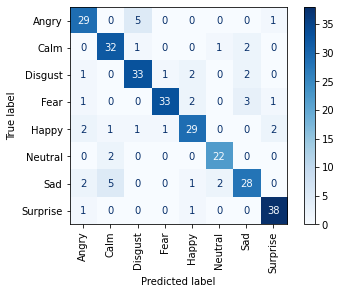

In [39]:
get_confusion_matrix(aug_y_labels, aug_y_pred, encoder)

# Weighted Model Averaging Ensemble
---

In [ ]:
# Weighted Ensemble Prediction
def weighted_ensemble_predictions(members, weights, test_dataset):
  # Make predictions for individual classifiers
  y_pred = [model.predict(test_dataset) for model in members]
  y_pred = np.array(y_pred)
 
  # Weighted sum across ensemble members
  y_pred = np.tensordot(y_pred, weights, axes = ((0), (0)))
 
  # Get predictions for the ensemble
  y_pred = np.argmax(y_pred, axis = 1)
  #y_pred = y_pred.astype(int).flatten()
  #y_pred = encoder.inverse_transform(y_pred)

  return y_pred

In [ ]:
def evaluate_ensemble(members, weights, test_dataset, labels):
  y_pred = weighted_ensemble_predictions(members, weights, test_dataset)
  return accuracy_score(labels, y_pred)

In [ ]:
# To normalize a vector to have unit norm
def normalize(weights):
  # Get l1 vector norm
  result = np.linalg.norm(weights, 1)

  # Check for vector of all zeros
  if result == 0.0:
    return weights
  
  # Return normalized vector
  return weights/result

In [ ]:
def grid_search(members, test_dataset, labels):
  # Weights to consider
  w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  best_score, best_weights = 0.0, None

  # Traverse all possible combinations
  for weights in product(w, repeat = len(members)):
    # If weights are equal, skip...
    if len(set(weights)) == 1:
      continue
    
    weights = normalize(weights)

    score = evaluate_ensemble(members, weights, test_dataset, labels)

    if score > best_score:
      best_score, best_weights = score, weights
      print(">%s %.3f" % (best_weights, best_score))

  return list(best_weights)

In [ ]:
labels = get_labels(y_test, encoder)

weights = grid_search(models, test_dataset, labels)
score = evaluate_ensemble(models, weights, test_dataset)
print("Grid Search Weights: %s, Score: %.3f" % (weights, score))

In [ ]:
def loss_func(weights, members, test_dataset, labels):
  normalized = normalize(weights)
  return 1.0 - evaluate_ensemble(models, normalized, test_dataset, labels)

In [ ]:
bound_weights = [(0.0, 1.0) for _ in range(3)]

In [ ]:
search_args = (models, test_dataset, labels)

In [ ]:
result = differential_evolution(loss_func, bound_weights, search_args, maxiter = 1000, tol = 1e-7)

In [ ]:
weights = normalize(result["x"])
print("Optimized Weights: %s" % weights)
score = evaluate_ensemble(models, weights, test_dataset, labels)
print("Optimized Weights Score: %.3f" % score)